A sample exercise for parametric and non-parametric resampling with bootstrapping. For full description please turn to https://medium.com/@aliaksei.mikhailiuk/a-note-on-parametric-and-non-parametric-bootstrap-resampling-72069b2be228

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.utils import resample
%matplotlib inline

In [222]:
def generate_prediction(x,pol_p,coef):
    '''
    Function to generate prediction for varied degree of the polynomial 
    params: 
    x: predictor, points at which response is estimated
    pol_p: polynomial power
    coef: coefficients of the polynomial
    '''
    
    yp = 0
    for ii in range(0,pol_p+1):
        yp = yp+coef[ii]*x**(pol_p-ii)
    return yp


In [225]:
# Data at hand, how many points we have initially 
number_of_points = 50

# Generate prediction for ... points
number_of_points_to_fit = 100

# Number of bootstrap samples
bootstrap_samples = 500

# Degree of the fitted polynomial
pol_p = 3

# Arrange number_of_points_to_fit equally spaced between 0 and 10, used to generate prediction and plots
x_plot = np.arange(0,10,10/number_of_points_to_fit)

# Arrange number_of_points equally spaced between 0 and 10, used to generate prediction
x = np.arange(0,10,10/number_of_points)

# Define the percentiles for the confidence intervals
bot_pct = int(bootstrap_samples*0.025)
top_pct = int(bootstrap_samples*0.925)

# Generate 0 centered noise from the beta distributino
noise = np.random.beta(a=6,b=20,size=len(x))*20
noise = noise-np.mean(noise)

# Define the signal
signal = 2*np.sin(x)+0.001*np.exp(x)

# Generate noisy data
y = signal+noise

# Fit the polynomial into the original data
coef_ml,res,_,_,_=np.polyfit(x, y, pol_p,full=True)

# Determine the standard deviation from the residual (used for parametric resampling)
std_dev_ml = np.sqrt(res/len(x))

# Generate MLE predictions for the noisy data
yp_plot = generate_prediction(x_plot,pol_p,coef_ml)
yp = generate_prediction(x,pol_p,coef_ml)



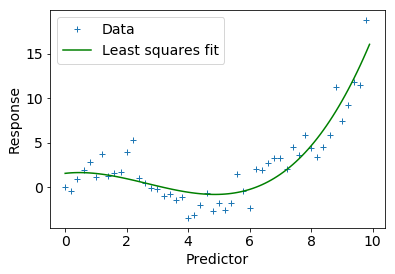

In [227]:
data_scatter, = plt.plot(x,y,'+', label = 'Data')
ls_fit, = plt.plot(x_plot,yp_plot,'g',  label = 'Least squares fit');
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.savefig('scatter.png')

In [228]:
def generate_coef_data_non_parametric(sample_x,sample_y):
    '''
    Function for non-parametric resample, fitting the data into the sample and generating predictions
    params:
    sample_x: original data x
    sample_y: original data y
    '''
    # Resample from the distribution
    sample_x, sample_y = resample(sample_x,sample_y,n_samples=number_of_points)
    # Find coefficients of the polynomial
    coef = np.polyfit(sample_x,sample_y,pol_p)
    # Find the fit
    yp_np = generate_prediction(x_plot,pol_p,coef) 
    return coef,yp_np


def generate_coef_data_parametric(sample_x, sample_y):
    '''
    Function for non-parametric resample, fitting the data into the sample and generating predictions
    params:
    sample_x: original data x
    sample_y: sample y generated in the previous iteration, in the 1st iteration use original response
    '''
    # Find coefficients and residuals from the new data sample
    coef=np.polyfit(sample_x, sample_y, pol_p)
    # Generate noise 0 centerd and standard deviation from the MLE fit into the original data
    noise= np.random.normal(loc = 0, scale = std_dev_ml, size = number_of_points)
    # Generate new sample of data to fit in 
    signal = generate_prediction(x_plot,pol_p,coef) 
    sample_y = yp+noise
    return coef, sample_y, signal


In [230]:
# Starting point for the parametric resampling
sample_y = y

# Arrays to hold output of the bootstrap rounds
coefs_p = np.empty((0,pol_p+1),float)
coefs_np = np.empty((0,pol_p+1),float)
predictions_p = np.empty((0,len(x_plot)),float)
predictions_np = np.empty((0,len(x_plot)),float)

# Go over bootstrap samples
for ii in range(0,bootstrap_samples):
    # Generate non-parametric data
    coef_np, yp_np = generate_coef_data_non_parametric(x,y)
    # Generate parametric data
    coef_p, sample_y, yp_p = generate_coef_data_parametric(x, sample_y)
    
    # Append results of the bootstrap iteration
    coefs_p = np.vstack((coefs_p,coef_p))
    coefs_np = np.vstack((coefs_np,coef_np)) 
    predictions_p = np.vstack((predictions_p,yp_p))
    predictions_np = np.vstack((predictions_np,yp_np))


In [231]:
# Generate confidence intervals for predictions
upper_bound_p = np.empty((0),float)
lower_bound_p = np.empty((0),float)
upper_bound_np = np.empty((0),float)
lower_bound_np = np.empty((0),float)
median_p =  np.empty((0),float)
median_np =  np.empty((0),float)
for ii in range(0,predictions_p.shape[1]):
    # For every datapoint (predictor) sort the prediction (response) from the bootstrap
    sorted_pred_p = np.sort(predictions_p[:,ii])
    sorted_pred_np = np.sort(predictions_np[:,ii])
    # Find the lower and upper bounds by subtracting  the/from MLE estimation from the points determined by the percentiles
    upper_bound_p = np.append(upper_bound_p, np.array([yp_plot[ii]-sorted_pred_p[bot_pct]]), axis = 0)
    lower_bound_p = np.append(lower_bound_p, np.array([sorted_pred_p[top_pct]-yp_plot[ii]]), axis = 0)
    upper_bound_np = np.append(upper_bound_np, np.array([yp_plot[ii]-sorted_pred_np[bot_pct]]), axis = 0)
    lower_bound_np = np.append(lower_bound_np, np.array([sorted_pred_np[top_pct]-yp_plot[ii]]), axis = 0)
    

In [232]:
# Generate confidence intervals for parameters

coeffs_upper_bound_p = np.empty((0),float)
coeffs_lower_bound_p = np.empty((0),float)
coeffs_upper_bound_np = np.empty((0),float)
coeffs_lower_bound_np = np.empty((0),float)

for ii in range(pol_p,-1,-1):
    # For every coefficient from the bootstrap sort the estimation
    coef_sort_p = np.sort(coefs_p[:,ii])
    coef_sort_np = np.sort(coefs_np[:,ii])
    # Fund lower and uper bounds
    coeffs_upper_bound_p = np.append(coeffs_upper_bound_p, coef_ml[ii]-coef_sort_p[bot_pct])
    coeffs_lower_bound_p = np.append(coeffs_lower_bound_p, coef_sort_p[top_pct]-coef_ml[ii])
    coeffs_upper_bound_np = np.append(coeffs_upper_bound_np, coef_ml[ii]-coef_sort_np[bot_pct])
    coeffs_lower_bound_np = np.append(coeffs_lower_bound_np, coef_sort_np[top_pct]-coef_ml[ii])



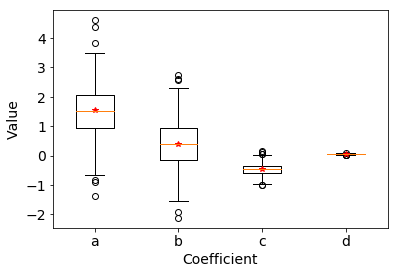

In [233]:
plt.boxplot([coefs_p[:,3],coefs_p[:,2],coefs_p[:,1],coefs_p[:,0]]);
plt.xticks([1, 2, 3,4], ['a', 'b', 'c','d']);
plt.plot([4,3,2,1],coef_ml,'r*')
plt.ylabel('Value',fontsize=14)
plt.xlabel('Coefficient',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

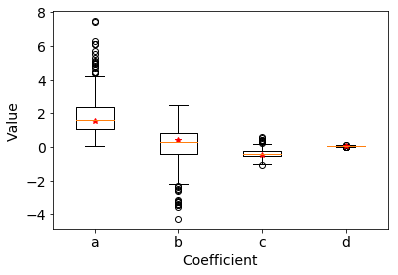

In [234]:
plt.boxplot([coefs_np[:,3],coefs_np[:,2],coefs_np[:,1],coefs_np[:,0]]);
plt.plot([4,3,2,1],coef_ml,'r*')
plt.xticks([1, 2, 3,4], ['a', 'b', 'c','d']);
plt.ylabel('Value',fontsize=14)
plt.xlabel('Coefficient',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


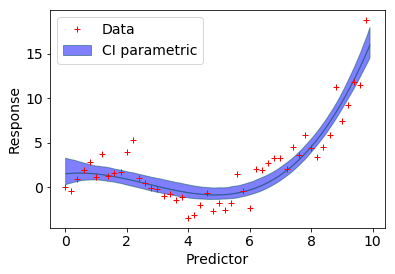

In [239]:
data_scatter, = plt.plot(x,y,'r+', label = 'Data')
ls_fit= plt.fill_between(x_plot, yp_plot, yp_plot-lower_bound_p, alpha=0.5,edgecolor='#055555', facecolor='blue', label = 'CI parametric')
plt.fill_between(x_plot, yp_plot, yp_plot+upper_bound_p,alpha=0.5,edgecolor='#055555', facecolor='blue')
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);



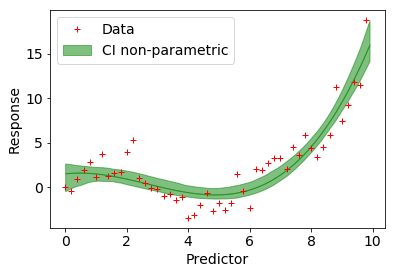

In [238]:


data_scatter, = plt.plot(x,y,'r+', label = 'Data')
ls_fit = plt.fill_between(x_plot, yp_plot, yp_plot-lower_bound_np, alpha=0.5,edgecolor='green', facecolor='green', label = 'CI non-parametric')
plt.fill_between(x_plot, yp_plot, yp_plot+upper_bound_np,alpha=0.5,edgecolor='green', facecolor='green');
plt.xlabel('Predictor',fontsize=14)
plt.ylabel('Response',fontsize=14);
plt.legend(handles=[data_scatter,ls_fit], loc=2,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);